# Facies discrimination using elemental intensities
Follows ML_element_02.ipynb, the SVC computation is submited manually without dask.

In [2]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# ML Gridsearch: RBF SVM
I've implemented steps with and without PCA together in one gridsearch (grid_svc.py and submit_svc.sh), which is more efficeint than separating them in a serial steps  (grid_svc_se.py and submit_svc.sh). There are several models take very long time for computing, so it's better to let the other CPUs compute other models parallely. The number of searched models is 2 (with or without PCA) * 9 (svc__gamma) * 7 (svc__C) * 5 (cv) = 630. It takes 11 hours to finish the gridsearch. The best model is without PCA and stored as roll_svc_model_ss_20201113.joblib. The job log is slurm-20678.txt. The best model's name is modified from roll_pca+svc_model_ss_20201113.joblib to roll_svc_model_ss_20201113.joblib. The cv-result's name is pca+svc because the the models with PCA are also included in the gridsearch. It's a bit confusing.

In [11]:
svc_df = pd.read_csv('results/roll_pca+svc_grid_ss_20201113.csv', index_col = 0)
len(svc_df)

126

In [4]:
np.max(svc_df.mean_test_score.astype(float))

0.6223694005559692

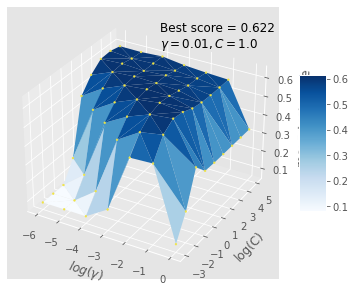

In [71]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = plt.gca(projection='3d')
xx = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'param_svc__gamma'].values.astype(float)
yy = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'param_svc__C'].values.astype(float)
zz = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'mean_test_score'].values.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap = cm.Blues, linewidth = 0.1)
ax.scatter(np.log10(xx), np.log10(yy), zz, c = 'C4', s = 3, alpha = 1)

# mark the best score
text = 'Best score = {:.3f}\n$\gamma = {}, C = {}$'.format(zz[max_index], xx[max_index], yy[max_index])
ax.text(-2, 0, .9,text, fontsize = 12)
#ax.quiver(np.log10(xx[max_index]), np.log10(yy[max_index]), zz[max_index], 
#          .3, .3, .3, color='gray', alpha=.6)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink = 0.5, aspect = 5)
fig.savefig('results/roll_svc_grid_20201113.png')

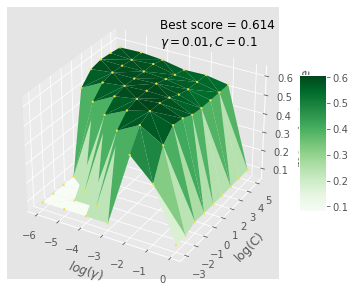

In [70]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = plt.gca(projection='3d')
xx = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'param_svc__gamma'].values.astype(float)
yy = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'param_svc__C'].values.astype(float)
zz = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'mean_test_score'].values.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap = cm.Greens, linewidth = 0.1)
ax.scatter(np.log10(xx), np.log10(yy), zz, c = 'C4', s = 3, alpha = 1)
# mark the best score
text = 'Best score = {:.3f}\n$\gamma = {}, C = {}$'.format(zz[max_index], xx[max_index], yy[max_index])
ax.text(-2, 0, .9,text, fontsize = 12)
#ax.quiver(np.log10(xx[max_index]), np.log10(yy[max_index]), zz[max_index], 
#          .3, .3, .3, arrow_length_ratio=0.1, color='gray', alpha=.6)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink = 0.5, aspect = 5)
fig.savefig('results/roll_pca+svc_grid_20201113.png')

# ML Gridsearch: RandomForest (RF)
Same logic. The steps with and without PCA together are implemented in one gridsearch (grid_rf.py and submit_rf.sh). Also, three amounts of n_estimators (100 (default), 1000, 5000) are searched. RF really comsumes a lot memory surign computation. The number of searched models is 2 (with or without PCA) * 3 (rf__n_estimators) * 5 (cv) = 30. It takes 12 minutes to finish the gridsearch. The best model is without PCA and stored as roll_rf_model_ss_20201116.joblib (2.5 GB). The job log is slurm-20722.txt.

In [81]:
rf_df = pd.read_csv('results/roll_rf_grid_ss_20201116.csv', index_col = 0)
len(rf_df)

6

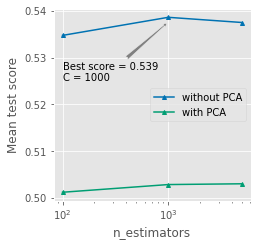

In [82]:
fig = plt.figure(figsize = (3.54, 3.54))

data_df = rf_df.copy()
x_col = 'param_rf__n_estimators'
max_index = np.argmax(data_df.mean_test_score)
plt.xscale('log')
#plt.ylim(0.545, 0.595)
plt.yticks(np.linspace(0.5, 0.54, 5))

for label, mask in zip(['without PCA', 'with PCA'], [data_df.param_pca != 'PCA(whiten=True)', data_df.param_pca == 'PCA(whiten=True)']):
    xx = data_df.loc[mask, x_col].values.astype(float)
    yy = data_df.loc[mask, 'mean_test_score'].values.astype(float)
    plt.plot(xx, yy, marker = '^', ms = 4, label = label)

plt.ylabel('Mean test score')
plt.xlabel('n_estimators')
plt.legend()

plt.annotate(text = 'Best score = {:.3f}\nC = {}'.format(data_df.mean_test_score[max_index], data_df.loc[max_index, x_col]),
             xy = (data_df.loc[max_index, x_col], data_df.mean_test_score[max_index]-.001),
             xytext = (100, 0.525), arrowprops=dict(facecolor='gray', arrowstyle = 'fancy')
            )
fig.subplots_adjust(wspace = 0.05)
fig.savefig('results/roll_rf_grid_ss_combined_{}.png'.format(date))

# Summary
From the grisdsearch results of lr, SVC, and RF, models learned from the data without PCA transformation provide better performance. The model of SVC has the best cv score, 0.62.